# Football Team Logo Classification Using CNNs


<p align="center">
  <img src="sliki/logo.png" width="700" height="370" style="margin-right: 40px; display: inline-block;"/>
  <img src="sliki/dataset-cover.jpg" width="700" height="370" style="margin-left: 40px; display: inline-block;"/>
</p>

## Project Overview

The goal of this project is to build a Convolutional Neural Network (CNN) capable of classifying football club logos.
The model is first trained on **La Liga team logos** and then adapted using **transfer learning** to classify **Serie A team logos**.

This approach allows us to:
- Learn general visual features from one league
- Reuse learned representations for a different but related dataset
- Reduce training time and improve generalization


## Dataset Description

<p align="center">
  <img src="sliki/LaLiga.png" width="720" height="400" style="margin-right: 40px; display: inline-block;"/>
  <img src="sliki/seriaA.jpg" width="720" height="400" style="margin-left: 40px; display: inline-block;"/>
</p>

This project uses two football logo datasets:

### La Liga Dataset
The La Liga dataset contains official club logos from Spanish football teams.
Each class represents one football club, and all images are organized in separate folders per team.

This dataset is used to:
- Train a CNN from scratch
- Learn general logo features such as shapes, colors, and symbols

### Serie A Dataset
The Serie A dataset contains Italian football club logos.
It is used only after the La Liga model has been trained.

This dataset is used to:
- Apply transfer learning
- Evaluate how well learned features generalize to a new league

## Importing Libraries and Downloading the Dataset

In this section, i import all required Python libraries and download the La Liga dataset using KaggleHub.
The dataset is automatically stored locally and accessed via its directory path.


In [31]:
import kagglehub
import os

laliga_path = kagglehub.dataset_download(
    "gorororororo23/laliga-team-logos-dataset-for-cnn"
)

print("Dataset path:", laliga_path)
print("Contents:", os.listdir(laliga_path))


Dataset path: C:\Users\BorjanCFC\.cache\kagglehub\datasets\gorororororo23\laliga-team-logos-dataset-for-cnn\versions\1
Contents: ['Laliga teams']


## Exploring the Dataset Structure

Before training, i inspect the dataset directory to ensure:
- Each team has its own folder
- Folder names correspond to class labels
- The dataset structure is compatible with `flow_from_directory`


In [32]:
laliga_path = os.path.join(laliga_path, os.listdir(laliga_path)[0])
os.listdir(laliga_path)


['Athletic Bilbao',
 'Atletico Madrid',
 'Barcelona',
 'Celta Vigo',
 'Deportivo Alaves',
 'Espanyol',
 'Getafe',
 'Girona',
 'Las Palmas',
 'Leganes',
 'Mallorca',
 'Osasuna',
 'Rayo Vallecano',
 'Real Betis',
 'Real Madrid',
 'Real Sociedad',
 'Real Valladolid',
 'Sevilla',
 'Valencia',
 'Villarreal']

In [4]:
print("Final dataset folders:")
for folder in os.listdir(laliga_path):
    print(folder)


Final dataset folders:
Athletic Bilbao
Atletico Madrid
Barcelona
Celta Vigo
Deportivo Alaves
Espanyol
Getafe
Girona
Las Palmas
Leganes
Mallorca
Osasuna
Rayo Vallecano
Real Betis
Real Madrid
Real Sociedad
Real Valladolid
Sevilla
Valencia
Villarreal


In [5]:
import matplotlib.pyplot as plt

class_names = sorted(os.listdir(laliga_path))

image_counts = []
for cls in class_names:
    cls_path = os.path.join(laliga_path, cls)
    image_counts.append(len(os.listdir(cls_path)))

print("Number of classes:", len(class_names))

Number of classes: 20


## Class Distribution Analysis

To ensure that the dataset is balanced, i visualize the number of images per class.
A balanced dataset helps prevent bias during training and improves model generalization.

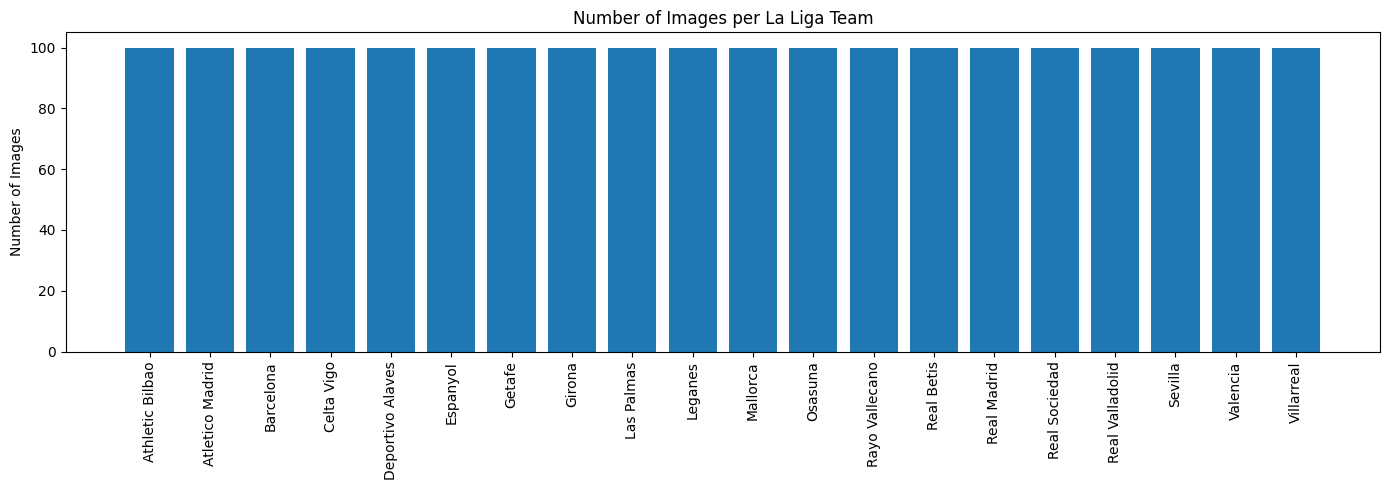

In [6]:
plt.figure(figsize=(14, 5))
plt.bar(class_names, image_counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.title("Number of Images per La Liga Team")
plt.tight_layout()
plt.show()


## Visualizing Sample Images

To better understand the dataset, i visualize:
- Multiple images from a few randomly selected teams
- Different logo orientations, styles, and color schemes

This helps verify dataset quality and highlights the need for data augmentation.


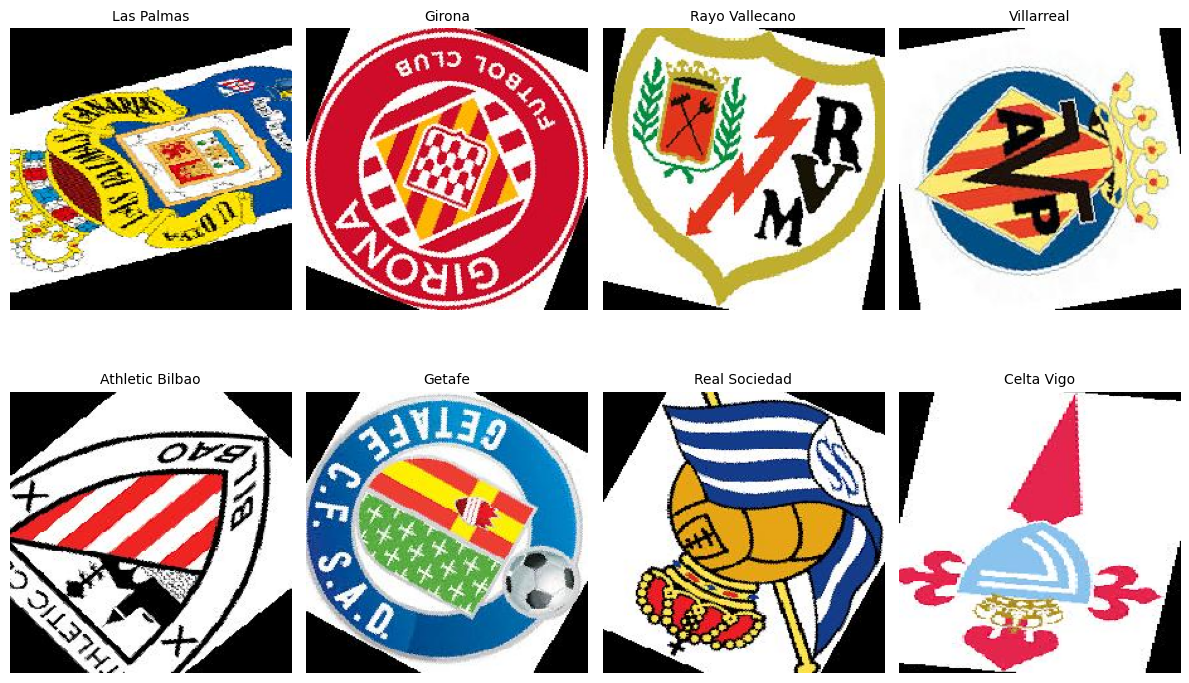

In [7]:
import random
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(12, 8))

for i, cls in enumerate(random.sample(class_names, 8)):
    cls_path = os.path.join(laliga_path, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()



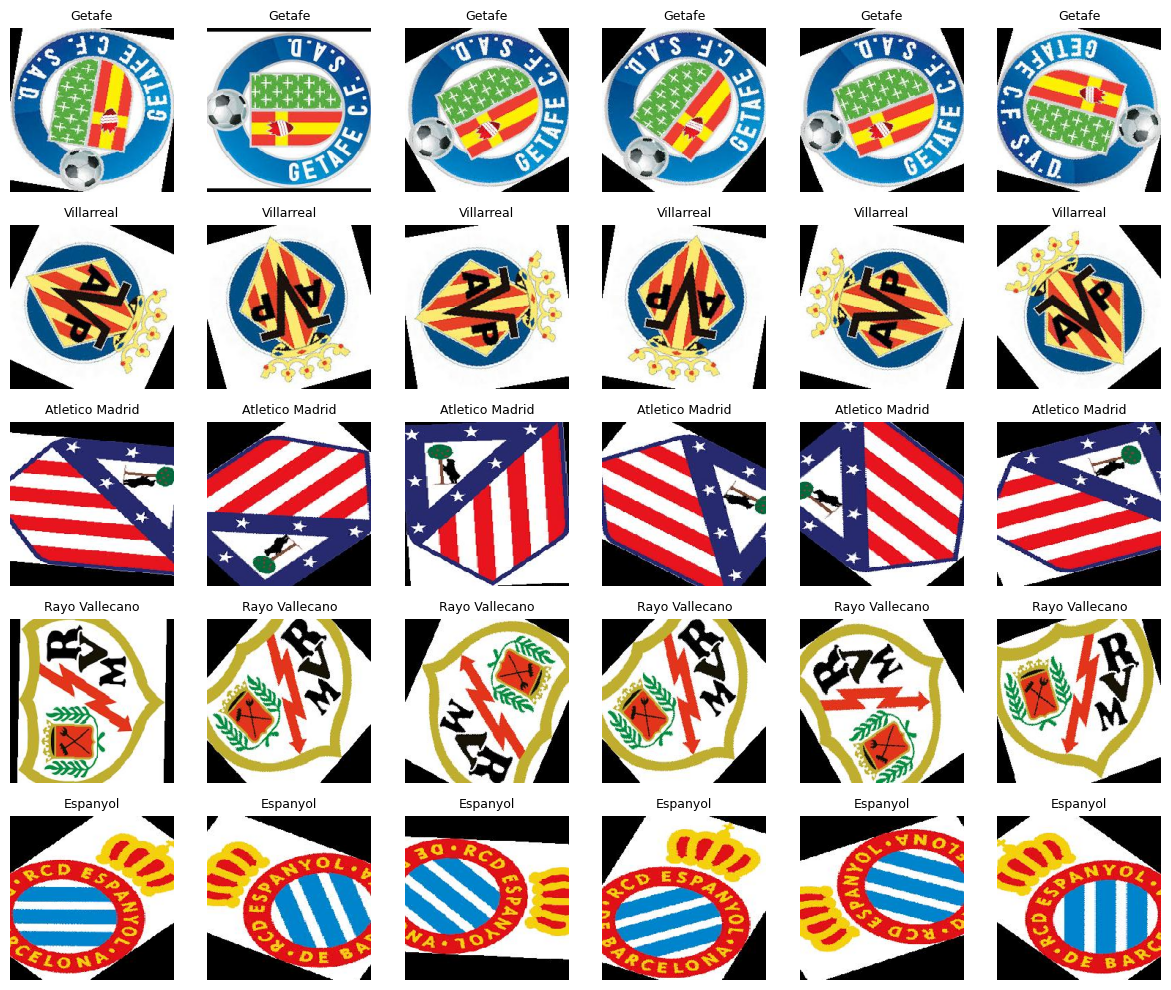

In [8]:
# select 5 random teams
teams = random.sample(os.listdir(laliga_path), 5)

plt.figure(figsize=(12, 10))

plot_index = 1
for team in teams:
    team_path = os.path.join(laliga_path, team)
    images = random.sample(os.listdir(team_path), 6)

    for img_name in images:
        img_path = os.path.join(team_path, img_name)
        img = image.load_img(img_path, target_size=(224, 224))

        plt.subplot(5, 6, plot_index)
        plt.imshow(img)
        plt.title(team, fontsize=9)
        plt.axis("off")

        plot_index += 1

plt.tight_layout()
plt.show()

### Setting the key parametars
- **Image size (`img_size`)**: All input images are resized to a fixed resolution of **56 × 56 pixels**.  
  This reduces computational complexity and training time while still preserving enough visual information for logo recognition.

- **Batch size (`batch_size`)**: A batch size of **32** is used, which provides a good balance between training stability and memory efficiency.

- **Random seed (`seed`)**: A fixed seed value is set to ensure **reproducibility**, allowing the same data splits and training behavior across multiple runs.

In [9]:
img_size = (56, 56)
batch_size = 32
seed = 42

## Data Preprocessing and Train/Validation Split

Next, i create a Keras `ImageDataGenerator` to normalize pixel values to the range **[0, 1]** using `rescale=1./255`, and automatically split the La Liga dataset into **80% training** and **20% validation** using `validation_split=0.2`.  
Then i load images from the folder structure with `flow_from_directory`, where each subfolder name is treated as a class label.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 80% train, 20% validation
)

train_generator = datagen.flow_from_directory(
    laliga_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=seed
)

val_generator = datagen.flow_from_directory(
    laliga_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)



Found 1600 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


## Verifying the Data Pipeline

Before training, i inspect a batch of images to confirm:
- Correct image dimensions
- Correct label encoding
- Proper pixel value normalization


In [11]:
x_batch, y_batch = next(train_generator)

print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)
print("Pixel range:", x_batch.min(), "to", x_batch.max())


x_batch shape: (32, 56, 56, 3)
y_batch shape: (32, 20)
Pixel range: 0.0 to 1.0


## Visualizing a Training Batch After Preprocessing

Before training the model, i visualize a batch of images generated by the data pipeline.
This step helps verify that:

- Images are correctly resized to the target input shape
- Labels match the corresponding images
- The data fed into the model is meaningful and correctly formatted



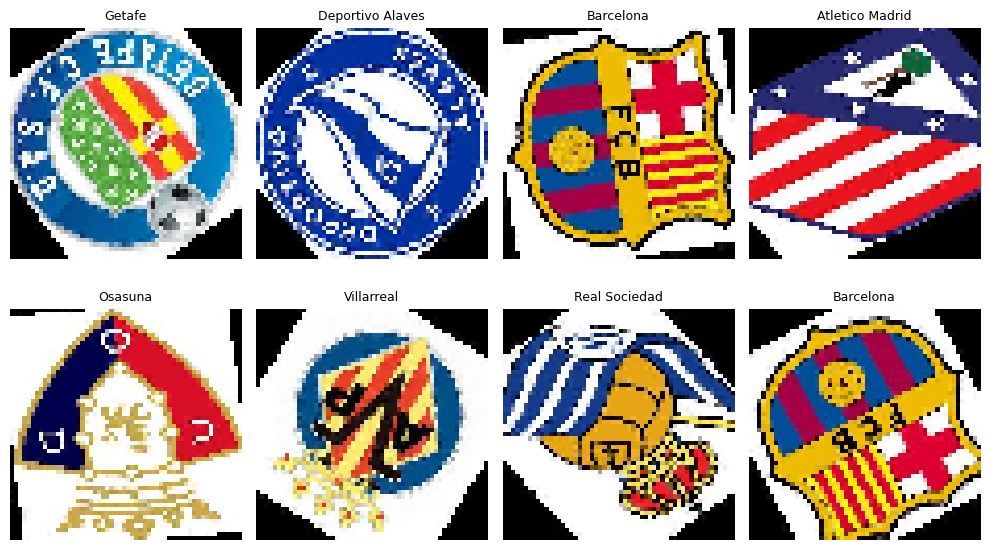

In [12]:
import numpy as np

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    label_idx = np.argmax(y_batch[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Baseline CNN Model Architecture

I define a Convolutional Neural Network consisting of:
- Convolution + MaxPooling blocks for feature extraction
- Fully connected layers for classification
- Dropout for regularization

This model serves as the baseline trained on La Liga logos.


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = train_generator.num_classes

model = models.Sequential([
    layers.Input(shape=(56, 56, 3)),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,828 (1.01 MB)

 Trainable params: 263,828 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


## Training the Baseline Model

The baseline CNN is trained on the La Liga training set and evaluated on the validation set.
Early stopping is used to prevent overfitting and restore the best-performing model weights.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        verbose=1
    ),
]


In [16]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.1719 - loss: 2.6743 - val_accuracy: 0.5825 - val_loss: 1.6365
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6056 - loss: 1.1984 - val_accuracy: 0.9925 - val_loss: 0.2381
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8731 - loss: 0.3939 - val_accuracy: 0.9925 - val_loss: 0.0838
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9269 - loss: 0.2168 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9656 - loss: 0.1109 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9588 - loss: 0.1219 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9800 - loss: 0.0780 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9837 - loss: 0.0620 - val_accuracy: 1.0000 - v

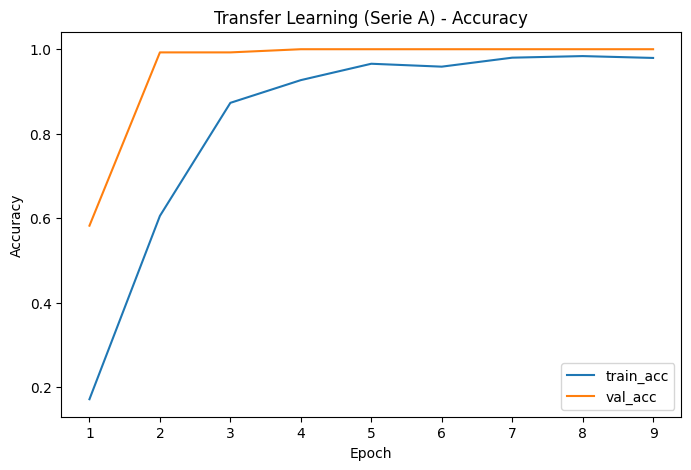

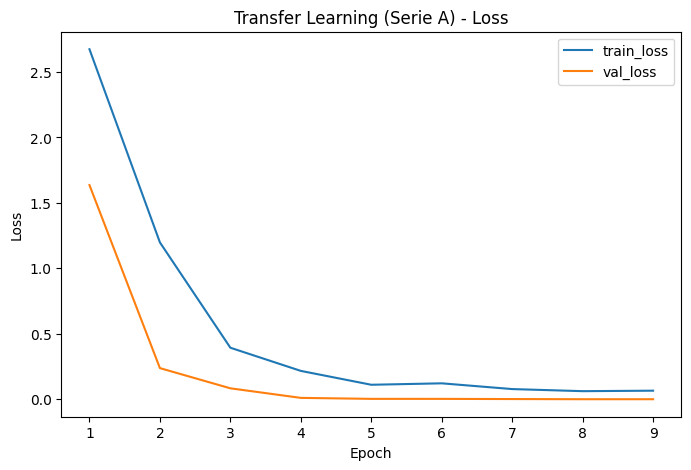

In [ ]:
def plot_history(hist, title="Training Curves"):
    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])
    
    epochs = range(1, len(acc)+1)
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history, "Training Baseline Model History")


## Data Augmentation

To improve generalization and reduce overfitting, data augmentation is applied only to the training set.
Augmentations include:
- Rotation
- Translation
- Zoom
- Shear
- Horizontal flipping

This helps the model become invariant to orientation and scale changes.


In [18]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    channel_shift_range=40.0,
    fill_mode="nearest"
)


val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    laliga_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=seed
)


val_generator = val_datagen.flow_from_directory(
    laliga_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 2000 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


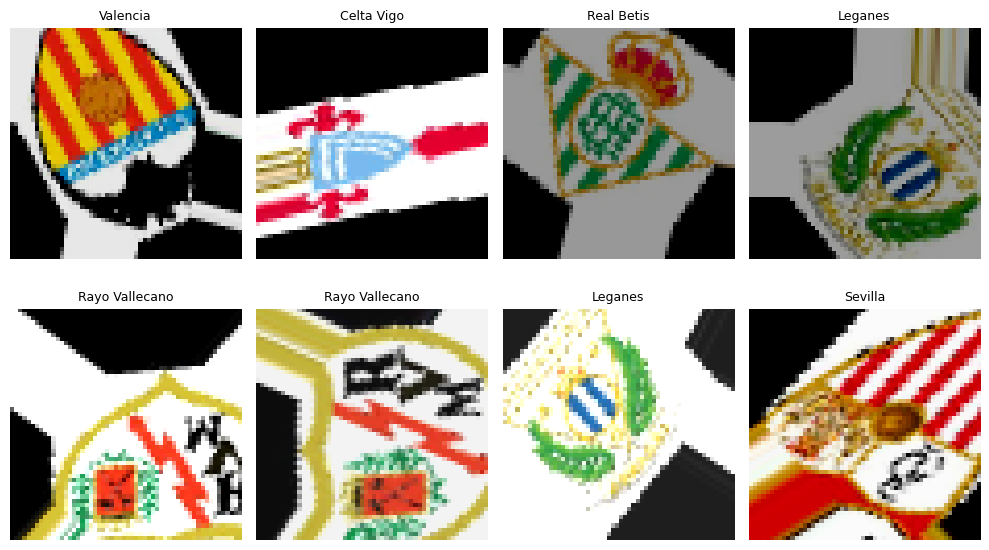

In [19]:
x_aug, y_aug = next(train_generator_aug)
class_names = list(train_generator_aug.class_indices.keys())

plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_aug[i])
    plt.title(class_names[np.argmax(y_aug[i])], fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Training with Data Augmentation

The same CNN architecture is retrained using augmented data.
This typically improves robustness and reduces overfitting compared to the baseline model.


In [20]:
num_classes = train_generator_aug.num_classes
model_aug = models.Sequential([
    layers.Input(shape=(56, 56, 3)),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation="softmax")
])

model_aug.summary()
model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 54, 54, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,828 (1.01 MB)

 Trainable params: 263,828 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "best_model_aug_laLiga.keras"
callbacks_aug = [
    EarlyStopping(
        monitor="val_accuracy",
        restore_best_weights=True,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

In [22]:
history_aug = model_aug.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks_aug
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0631 - loss: 2.9566
Epoch 1: val_accuracy improved from None to 0.23500, saving model to best_model_aug_laLiga.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.1030 - loss: 2.8382 - val_accuracy: 0.2350 - val_loss: 2.1760
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2338 - loss: 2.3957
Epoch 2: val_accuracy improved from 0.23500 to 0.57000, saving model to best_model_aug_laLiga.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2730 - loss: 2.2479 - val_accuracy: 0.5700 - val_loss: 1.3797
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4237 - loss: 1.7599
Epoch 3: val_accuracy improved from 0.57000 to 0.90750, saving model to best_model_aug_laLiga.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4340 - loss: 1.7071 - val_accuracy: 0.9075 - val_loss: 0.7485
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5226 - loss: 1.4075
Epoch 4: val_ac

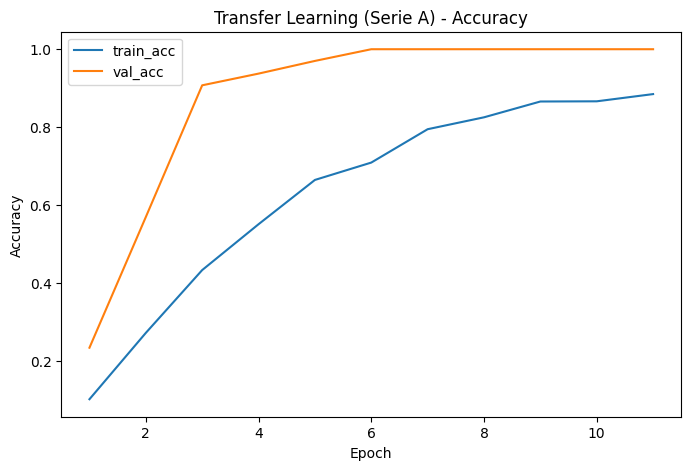

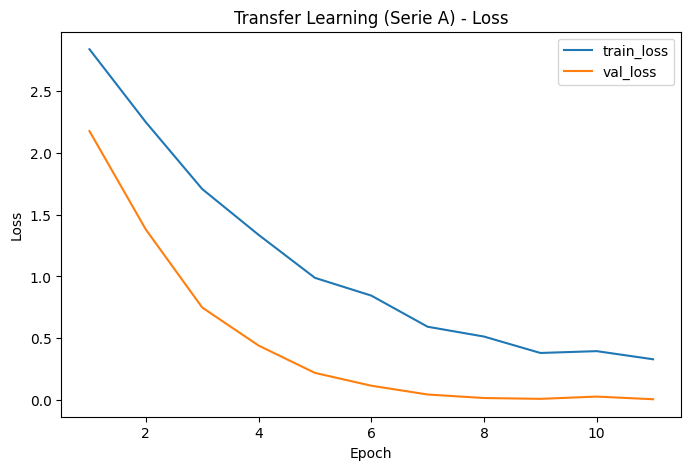

In [23]:
def plot_history(hist, title="Training Curves"):
    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])
    
    epochs = range(1, len(acc)+1)
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history_aug, "Transfer Learning (Serie A)")


## Downloading the Serie A Dataset

In this section, i download the **Serie A football team logos dataset** using KaggleHub.
The dataset contains club logos for all teams competing in Serie A and will be used
as a **target dataset** for transfer learning.

After downloading, i inspect the dataset directory to confirm that the files were
successfully retrieved and to understand the folder structure.


In [24]:
import kagglehub
import os

seriea_path = kagglehub.dataset_download("gorororororo23/seria-a-team-logos-dataset-for-cnn")
print("Downloaded:", seriea_path)
print("Contents:", os.listdir(seriea_path))


Downloaded: C:\Users\BorjanCFC\.cache\kagglehub\datasets\gorororororo23\seria-a-team-logos-dataset-for-cnn\versions\1
Contents: ['Seria A teams']


In [25]:
seriea_path = os.path.join(seriea_path, os.listdir(seriea_path)[0])
print("Final Serie A path:", seriea_path)
print("Teams:", os.listdir(seriea_path)[:10])


Final Serie A path: C:\Users\BorjanCFC\.cache\kagglehub\datasets\gorororororo23\seria-a-team-logos-dataset-for-cnn\versions\1\Seria A teams
Teams: ['AC Milan', 'AC Monza', 'Atalanta', 'Bologna', 'Cagliari', 'Como 1907', 'Empoli', 'Fiorentina', 'Genoa', 'Inter Milan']


## Creating Train, Validation, and Test Splits

To properly evaluate model performance and avoid data leakage, the dataset is
manually split into three subsets:

- **Training set (70%)** – used to learn model parameters  
- **Validation set (15%)** – used for hyperparameter tuning and early stopping  
- **Test set (15%)** – used only for final evaluation  

The split is performed **per class**, ensuring that each team is equally represented
across all subsets. A fixed random seed is used to guarantee reproducibility.


In [26]:
import os, shutil, random

random.seed(42)

source_dir = seriea_path
output_dir = "seriea_split_70_15_15"

train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15


## Organizing Images into Split Directories

In this step, the images are copied into a new directory structure organized as:

- `train/`
- `val/`
- `test/`

Each split contains subfolders for every team, preserving the class labels.
This directory layout is required for using `flow_from_directory()` in Keras.


In [27]:
# create folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

teams = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

for team in teams:
    team_src = os.path.join(source_dir, team)
    images = [f for f in os.listdir(team_src) if os.path.isfile(os.path.join(team_src, f))]
    random.shuffle(images)

    n = len(images)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    for split_name, split_imgs in [("train", train_imgs), ("val", val_imgs), ("test", test_imgs)]:
        split_team_dir = os.path.join(output_dir, split_name, team)
        os.makedirs(split_team_dir, exist_ok=True)

        for img_name in split_imgs:
            src_path = os.path.join(team_src, img_name)
            dst_path = os.path.join(split_team_dir, img_name)
            shutil.copy2(src_path, dst_path)


## Verifying the Loaded Data

After initializing the data generators, i verify that:

- The number of images in each split
- The number of classes

This confirmation step helps ensure that the dataset preparation was performed correctly
before proceeding to model training.


### Training Generator
For the training set, **data augmentation** is applied to improve generalization and reduce overfitting.  
The augmentations include:
- Random rotations
- Width and height shifts
- Zooming
- Shearing
- Horizontal flipping
- Brightness variation
- Channel shifting

### Validation & Test Generators
For validation and testing, **only rescaling** is applied.
No augmentation is used to ensure unbiased evaluation.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seriea_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    channel_shift_range=40.0,
    fill_mode="nearest"
)

seriea_eval_datagen = ImageDataGenerator(rescale=1./255)

seriea_train_generator = seriea_train_datagen.flow_from_directory(
    os.path.join(output_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=seed
)

seriea_val_generator = seriea_eval_datagen.flow_from_directory(
    os.path.join(output_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

seriea_test_generator = seriea_eval_datagen.flow_from_directory(
    os.path.join(output_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 1400 images belonging to 20 classes.
Found 300 images belonging to 20 classes.
Found 300 images belonging to 20 classes.


## Loading the Pretrained La Liga Model

In this section, i load the previously trained CNN model for La Liga team logo classification.
This model was trained with data augmentation and serves as a strong feature extractor for
transfer learning.


In [27]:

laliga_full = tf.keras.models.load_model("best_model_aug_laLiga.keras")
laliga_full.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 54, 54, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 791,486 (3.02 MB)

 Trainable params: 263,828 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 527,658 (2.01 MB)

## Creating a Frozen Convolutional Base

To apply transfer learning, i reuse the convolutional layers of the trained La Liga model
as a fixed feature extractor. The model is truncated at the last convolutional block,
removing the original classification head.


Here, we iterate through the layers of the pretrained La Liga model and stop at a chosen
convolutional layer. The resulting model represents the convolutional base, which outputs
high-level feature maps instead of class predictions.

The convolutional base is frozen to prevent its weights from being updated during training.
This ensures that the previously learned features remain unchanged and helps stabilize
training when only a limited amount of new data is available.


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

laliga_full = tf.keras.models.load_model("best_model_aug_laliga.keras")

cut_layer_name = "max_pooling2d_5"

inp = layers.Input(shape=(56, 56, 3))
x = inp

for layer in laliga_full.layers:
    x = layer(x)
    if layer.name == cut_layer_name:
        break

conv_base = models.Model(inp, x, name="laliga_conv_base")
conv_base.trainable = False
conv_base.summary()


Model: "laliga_conv_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 56, 56, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 54, 54, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 56,320 (220.00 KB)

## Building the Serie A Transfer Learning Model

A new classification head is added on top of the frozen convolutional base.
This head consists of:
- A flattening layer to convert feature maps into vectors
- A dense layer with ReLU activation
- A dropout layer for regularization
- A final softmax layer for multi-class classification

In [36]:
num_seriea_classes = seriea_train_generator.num_classes

inputs = layers.Input(shape=(56, 56, 3))
x = conv_base(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(num_seriea_classes, activation="softmax")(x)

transfer_model = models.Model(inputs, outputs, name="seriea_transfer_model")
transfer_model.summary()


Model: "seriea_transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 56, 56, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ laliga_conv_base (Functional)   │ (None, 5, 5, 64)       │        56,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,084 (625.33 KB)

 Trainable params: 103,764 (405.33 KB)

 Non-trainable params: 56,320 (220.00 KB)

## Model Compilation and Callbacks

The model is compiled using:
- **Adam optimizer** with a low learning rate
- **Categorical cross-entropy** loss
- **Accuracy** as the evaluation metric

Two callbacks are used:
- **EarlyStopping** to prevent overfitting
- **ModelCheckpoint** to save the best-performing model based on validation accuracy


## Training the Model

The transfer learning model is trained using:
- Augmented training data
- A separate validation set
- Early stopping for regularization

Training continues until validation performance stops improving.


In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "best_seriea_transfer.keras"

callbacks_tl = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]


In [38]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_tl = transfer_model.fit(
    seriea_train_generator,
    validation_data=seriea_val_generator,
    epochs=30,
    callbacks=callbacks_tl
)

Epoch 1/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0682 - loss: 3.1848
Epoch 1: val_accuracy improved from None to 0.32667, saving model to best_seriea_transfer.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.0907 - loss: 3.0225 - val_accuracy: 0.3267 - val_loss: 2.4846
Epoch 2/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1514 - loss: 2.7116
Epoch 2: val_accuracy improved from 0.32667 to 0.35667, saving model to best_seriea_transfer.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1671 - loss: 2.6483 - val_accuracy: 0.3567 - val_loss: 2.2265
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1995 - loss: 2.4813
Epoch 3: val_accuracy improved from 0.35667 to 0.45000, saving model to best_seriea_transfer.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2200 - loss: 2.4686 - val_accuracy: 0.4500 - val_loss: 2.0356
Epoch 4/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2339 - loss: 2.4109
Epoch 4: val_accur

## Evaluating the Model on the Test Set

After training, the best saved model is evaluated on the **held-out test set**.

This provides an unbiased estimate of the model’s real-world performance.


In [39]:
test_loss, test_acc = transfer_model.evaluate(seriea_test_generator, verbose=1)
print(f"Serie A TEST Accuracy: {test_acc:.4f}")
print(f"Serie A TEST Loss: {test_loss:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9733 - loss: 0.7538
Serie A TEST Accuracy: 0.9733
Serie A TEST Loss: 0.7538


## Confusion Matrix Analysis

The confusion matrix visualizes the model’s predictions across all Serie A teams.

It helps identify:
- Correct classifications (diagonal values)
- Misclassifications between visually similar logos

The strong diagonal dominance indicates **excellent classification performance** across all classes.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<Figure size 1200x1200 with 0 Axes>

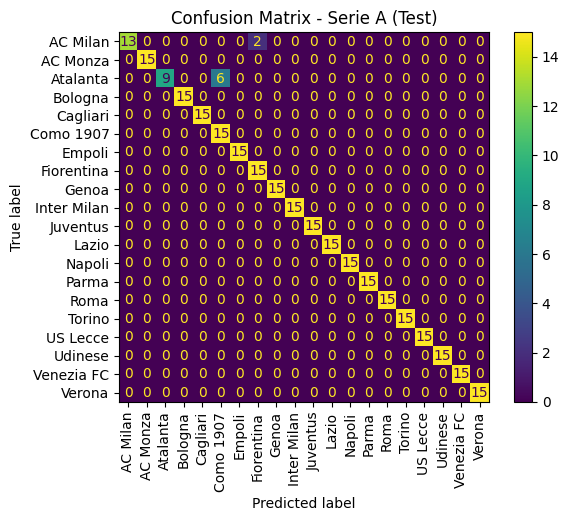

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# IMPORTANT: reset generator so order is correct
seriea_test_generator.reset()

# Predict probabilities -> class index
y_pred_probs = transfer_model.predict(seriea_test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = seriea_test_generator.classes

# Class names in the SAME order as indices
idx_to_class = {v:k for k,v in seriea_test_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=90, cmap=None, values_format="d")
plt.title("Confusion Matrix - Serie A (Test)")
plt.show()

## Classification Report

A detailed classification report is produced, including:
- precision
- recall
- F1-score
- support

These metrics provide deeper insight into model performance for each team and confirm whether class imbalance or specific weaknesses exist.


In [41]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


              precision    recall  f1-score   support

    AC Milan     1.0000    0.8667    0.9286        15
    AC Monza     1.0000    1.0000    1.0000        15
    Atalanta     1.0000    0.6000    0.7500        15
     Bologna     1.0000    1.0000    1.0000        15
    Cagliari     1.0000    1.0000    1.0000        15
   Como 1907     0.7143    1.0000    0.8333        15
      Empoli     1.0000    1.0000    1.0000        15
  Fiorentina     0.8824    1.0000    0.9375        15
       Genoa     1.0000    1.0000    1.0000        15
 Inter Milan     1.0000    1.0000    1.0000        15
    Juventus     1.0000    1.0000    1.0000        15
       Lazio     1.0000    1.0000    1.0000        15
      Napoli     1.0000    1.0000    1.0000        15
       Parma     1.0000    1.0000    1.0000        15
        Roma     1.0000    1.0000    1.0000        15
      Torino     1.0000    1.0000    1.0000        15
    US Lecce     1.0000    1.0000    1.0000        15
     Udinese     1.0000    

## Training Curves (Accuracy and Loss)

Training and validation accuracy and loss curves are plotted across epochs.  
These curves help diagnose:
- overfitting
- underfitting
- convergence behavior

The close alignment between training and validation curves indicates strong generalization performance.


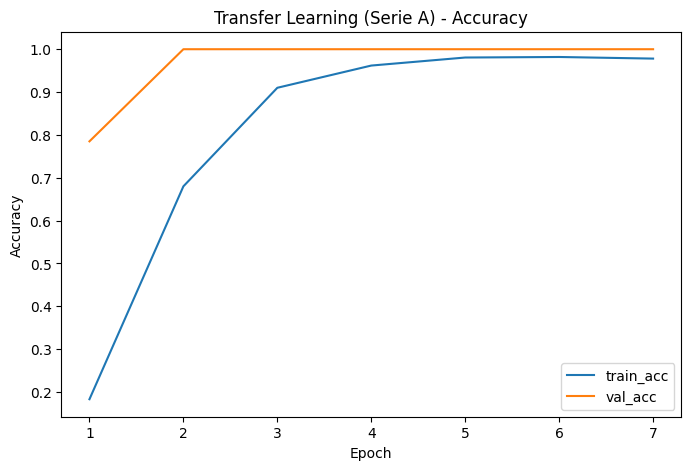

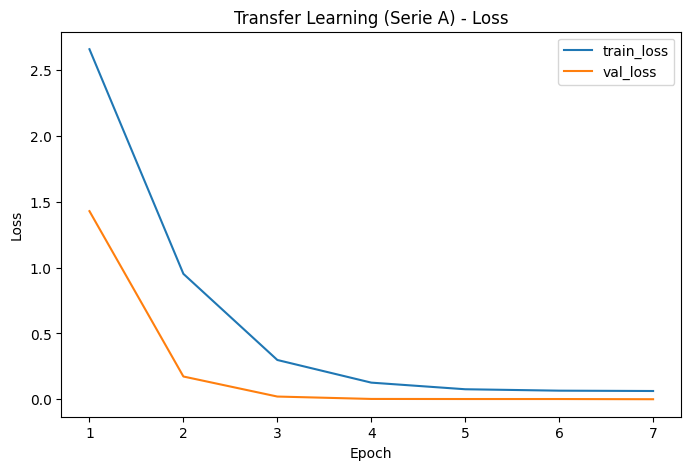

In [42]:
def plot_history(hist, title="Training Curves"):
    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])
    
    epochs = range(1, len(acc)+1)
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history, "Transfer Learning (Serie A)")


## Summary

This notebook demonstrates a complete **transfer learning pipeline** for football team logo classification:
- Dataset exploration and preprocessing
- Data augmentation
- Model reuse via transfer learning
- Training with regularization
- Thorough evaluation using accuracy and confusion matrices

The results show that transfer learning is highly effective for logo recognition tasks, even with relatively small datasets.
